# Clustering Crypto

In [207]:
# Initial imports
import requests
from pathlib import Path                                      #for writing paths to files
import pandas as pd                                           #tools for DataFrames
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler #for standardizing data 
from sklearn.decomposition import PCA                          #for PCA
from sklearn.cluster import KMeans                            #for K-means
import json                                                  #for extracting json content
import numpy as np

### Fetching Cryptocurrency Data

In [208]:
# Use the following endpoint to fetch json data
#url = "https://min-api.cryptocompare.com/data/all/coinlist"

#Making Initial Lists for Dictionary
#Symbol=[]
#CoinName=[]
#Algorithm=[]
#ProofType=[]
#IsTrading=[]
#TotalCoinsMined=[]
#TotalCoinSupply=[]

In [209]:
# Alternatively, use the provided csv file:
file_path = Path("Resources/crypto_data.csv")
coin_df=pd.read_csv(file_path,index_col="Unnamed: 0")
coin_df.head()



,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [210]:
# Keep only cryptocurrencies that are trading
coin_df=coin_df[coin_df['IsTrading']==True]
coin_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [186]:
# Keep only cryptocurrencies with a working algorithm
#np.unique(list(coin_df['Algorithm']))

In [211]:
# Remove the "IsTrading" column
coin_df.drop(columns=['IsTrading'],inplace=True)
coin_df.head()


,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
365,365Coin,X11,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,PoW,NaN,611000
808,808,SHA-256,PoW/PoS,0.000000e+00,0


In [212]:
# Remove rows with at least 1 null value
coin_df.dropna(inplace=True)
coin_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
808,808,SHA-256,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000


In [214]:
# Remove rows with cryptocurrencies having no coins mined
coin_df['TotalCoinSupply']=coin_df['TotalCoinSupply'].values.astype(float) #converting "Total Coin Supply" column to floats
coin_df=coin_df[coin_df["TotalCoinSupply"]>0]
coin_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,3.141593e+11
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,2.100000e+07
LTC,Litecoin,Scrypt,PoW,6.303924e+07,8.400000e+07


In [215]:
# Drop rows where there are 'N/A' text values: for each row make a SET of its entries, then check if N/A is in set
#'N/A' in list(coin_df.iloc[1].values)
#for index, item in coin_df.iterrows():
#    'N/A' in list(item.values)
#    print(item.values)
    
    
no_NAs=['N/A' not in list(item.values) for index,item in coin_df.iterrows()]  #finding rows that don't have NAs
coin_df=coin_df[no_NAs]                                                       #refining the DataFrame
coin_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,3.141593e+11
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,2.100000e+07
LTC,Litecoin,Scrypt,PoW,6.303924e+07,8.400000e+07


In [216]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_name_df=coin_df["CoinName"]                        #storing the coin name for later
coin_algo=coin_df['Algorithm']
coin_proof=coin_df['ProofType']

In [217]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
coin_df.drop(columns=['CoinName'],inplace=True)
coin_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01
404,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08
1337,X13,PoW/PoS,2.927942e+10,3.141593e+11
BTC,SHA-256,PoW,1.792718e+07,2.100000e+07
LTC,Scrypt,PoW,6.303924e+07,8.400000e+07


In [218]:
# Create dummy variables for text features: create function that determines if there are alphabets, then select those columns
coin_df = pd.get_dummies(coin_df, columns=["Algorithm", "ProofType"])
coin_df.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,4.200000e+01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,5.320000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,3.141593e+11,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LTC,6.303924e+07,8.400000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [219]:
# Standardize data
data_scaler = StandardScaler()
data_scaler.fit(coin_df) 
coin_data_scaled = data_scaler.transform(coin_df)


### Reducing Dimensions Using PCA

In [220]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3,random_state=0)                                  #making PCA model object with 3 principal components
coin_data_pca = pca.fit_transform(coin_data_scaled)         #getting principle components from standardized data
coin_data_pca

array([[-1.23054366e-01,  1.18657219e+00, -5.04638516e-01],
       [-1.08770966e-01,  1.18469794e+00, -5.04960453e-01],
       [ 3.33340858e-01,  1.90869146e+00, -5.85853790e-01],
       ...,
       [-2.31119396e-01, -2.25771347e+00,  3.52842521e-01],
       [-2.00040970e-01, -1.78895239e+00,  2.90976968e-01],
       [ 7.53971819e-04,  8.72313465e-01, -2.55853900e-01]])

In [221]:
# Create a DataFrame with the principal components data
df_coin_data_pca = pd.DataFrame(index=coin_df.index,
    data=coin_data_pca, columns=["PC 1", "PC 2","PC 3"]
)
df_coin_data_pca.head()

,PC 1,PC 2,PC 3
42,-0.123054,1.186572,-0.504639
404,-0.108771,1.184698,-0.504960
1337,0.333341,1.908691,-0.585854
BTC,-0.249831,-1.410456,0.172146
LTC,-0.243440,-1.041747,0.003085


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [222]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
inertia = []                                     #initialization of inertia list; storing inertia values
k = list(range(1, 11))                           #making list of values for k

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)    #creating instance of K-means algorithm with value k
    km.fit(df_coin_data_pca)                          #running K-means algorithm for value of k         
    inertia.append(km.inertia_)                  #computing the inertia value for K-means model

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}       #creating dictionary from K-mean resutls
df_elbow = pd.DataFrame(elbow_data)             #making DataFrame from K-means dictionary
df_elbow.hvplot.line(x="k", y="inertia", xticks=k,title="Elbow Curve")     #plotting the results


:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [223]:
# Initialize the K-Means model
# Fit the model
km = KMeans(n_clusters=5, random_state=0)
km.fit(df_coin_data_pca)                                     #fitting K-means model to data

# Predict clusters
predictions = pd.DataFrame(km.labels_,columns=['Class'],index=coin_df.index)          #making predictions with the model

# Create a new DataFrame including predicted clusters and cryptocurrencies features
coin_df=pd.concat([coin_df,df_coin_data_pca,predictions,coin_name_df,coin_algo,coin_proof],axis=1,join='inner')
reorder_columns=['Algorithm','ProofType','TotalCoinsMined','TotalCoinSupply','PC 1','PC 2','PC 3','CoinName','Class']
coin_df=coin_df[reorder_columns]
#coin_df.head(10)

### Visualizing Results

#### 3D-Scatter with Clusters

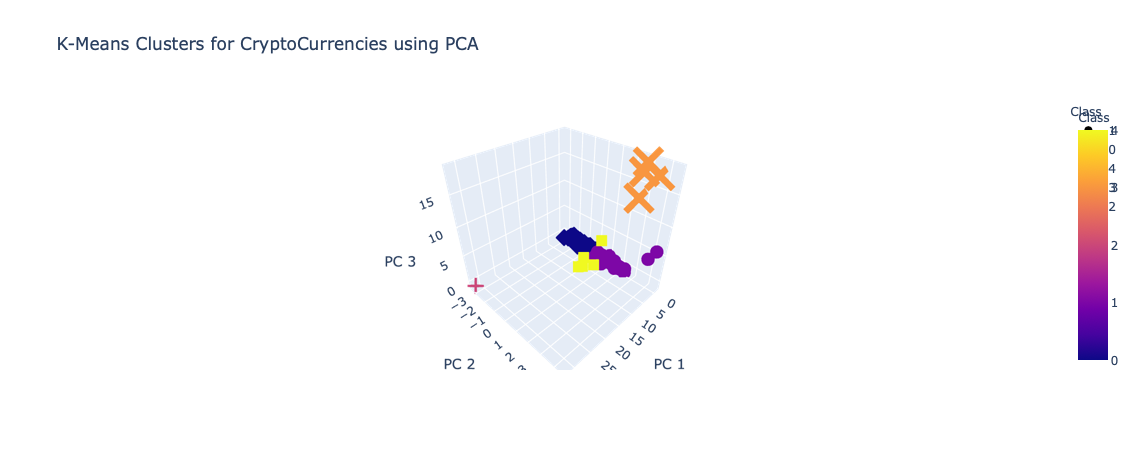

In [224]:

# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    coin_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="Class",
    symbol="Class",
    width=800,
    hover_name="CoinName",
    hover_data=["Algorithm"],
    title="K-Means Clusters for CryptoCurrencies using PCA",
)
#fig.update_layout(legend=dict(x=0, y=1))
fig.show()





#### Table of Tradable Cryptocurrencies

In [237]:
# Table with tradable cryptos
coin_df.hvplot.table(columns=["CoinName", "Algorithm", "ProofType", "TotalCoinSupply", "TotalCoinsMined", "Class"])


:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

In [238]:
# Print the total number of tradable cryptocurrencies
crypto_total=coin_df['CoinName'].count()
print("The total number of tradable cryptocurrencies is: "+str(crypto_total))


The total number of tradable cryptocurrencies is: 637


#### Scatter Plot with Tradable Cryptocurrencies

In [239]:
# Scale data to create the scatter plot
mm_scale=MinMaxScaler()
coin_df[["TotalCoinsMined","TotalCoinSupply"]]=mm_scale.fit_transform(coin_df[["TotalCoinsMined","TotalCoinSupply"]])


In [242]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
coin_df.hvplot.scatter(x="TotalCoinsMined",y="TotalCoinSupply",by="Class",hover_cols=["CoinName"],title="Total Coin Supply vs Total Coins Mined Scatter Plot")

:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)